# Continuous Treatment Simulation
Standalone implementation of the Kang-Schafer continuous treatment simulation

Running well-specified continuous Kang-Schafer simulation...
  Sample size: 100
    Simulation 1/5
  Sample size: 250
    Simulation 1/5
  Sample size: 500
    Simulation 1/5
  Sample size: 1000
    Simulation 1/5
  Sample size: 2000
    Simulation 1/5
  Sample size: 5000
    Simulation 1/5
Well-specified simulation completed in 997.5 seconds
Running misspecified continuous Kang-Schafer simulation...
  Sample size: 100
    Simulation 1/5
  Sample size: 250
    Simulation 1/5
  Sample size: 500
    Simulation 1/5
  Sample size: 1000
    Simulation 1/5
  Sample size: 2000
    Simulation 1/5
  Sample size: 5000
    Simulation 1/5
Misspecified simulation completed in 871.4 seconds


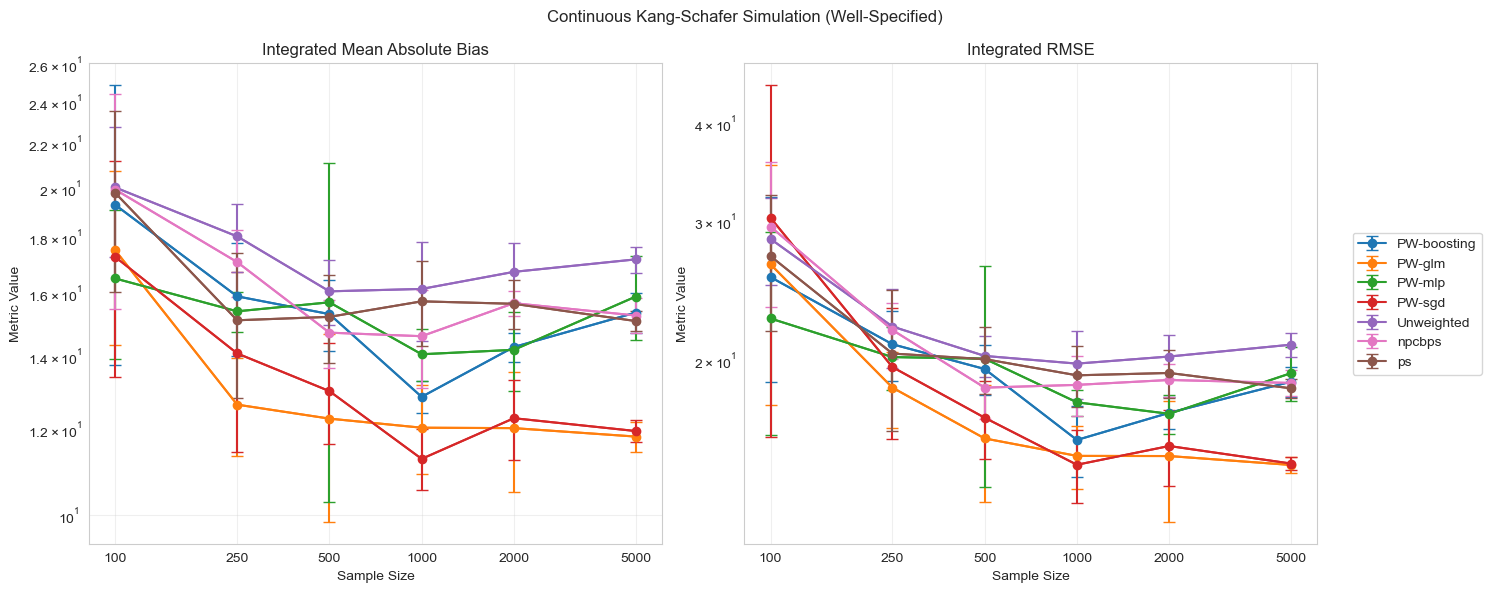

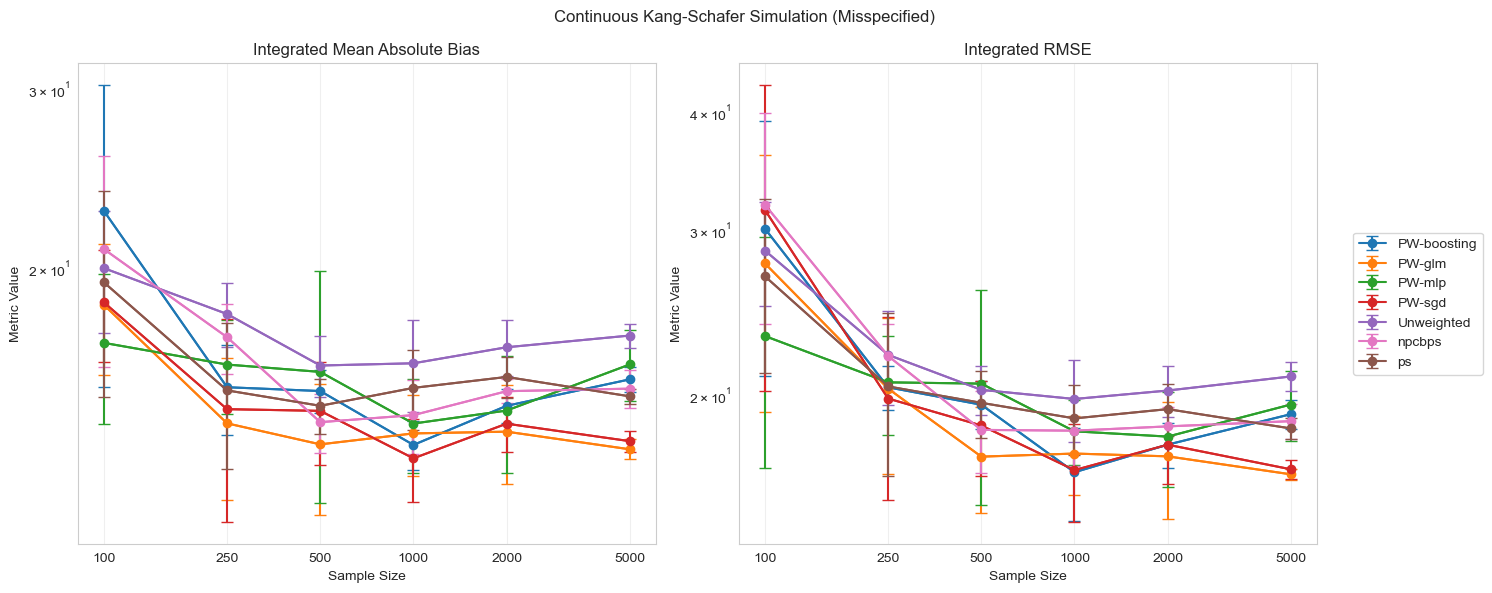

In [1]:
"""
Standalone implementation of the Kang-Schafer continuous treatment simulation.
This script directly implements the permutation weighting approach from the R code,
without relying on external packages.

Based on the R implementation in:
- run_ks_continuous_sim.R
- kang_schafer_continuous.R
- continuous_simulation.R
- weighting.R
- weighting-class.R
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import time
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(100)

def create_kang_schafer_continuous_dgp(n, misspecified=False, extraneous_covs=0, trt_noise_sd=1, logit=True):
    """
    Generate data according to Kang and Schafer (2007) simulation with continuous treatment.
    Directly matches the create_kang_schafer_continuous_dgp function in kang_schafer_continuous.R
    """
    # Generate true covariates (matching R's mvrnorm)
    sigma = np.eye(4 + extraneous_covs)
    mus = np.zeros(4 + extraneous_covs)
    X_true = np.random.multivariate_normal(mus, sigma, n)
    
    # Set coefficients for treatment (matches R)
    co = np.zeros(4 + extraneous_covs)
    co[:4] = np.array([1, -0.5, 0.25, 0.1])
    
    # Linear predictor for treatment
    z_score = np.dot(X_true, co)
    
    # Treatment function: R uses 1/(1+exp(z)) which decreases as z increases
    trt_fn = lambda z: 1 / (1 + np.exp(z)) if logit else z
    
    # True outcome (without treatment effect)
    Outcome = 210 + 27.4 * X_true[:, 0] + 13.7 * X_true[:, 1] + 13.7 * X_true[:, 2] + 13.7 * X_true[:, 3]
    
    # Random noise for outcome
    outcome_noise = np.random.normal(0, 1, n)
    
    # Function to draw dosage (treatment value)
    def draw_dose():
        noise = np.random.normal(0, trt_noise_sd, n)
        return z_score + noise
    
    # Function to calculate test points for evaluation
    def draw_test_points(n_points):
        q = np.linspace(0.05, 0.95, n_points)
        Vz_score = np.dot(np.dot(co, sigma), co)
        Ez_score = np.sum(mus * co)
        test_noise = norm.ppf(q, loc=Ez_score, scale=np.sqrt(Vz_score) + trt_noise_sd)
        return Ez_score + test_noise
    
    # Function to draw outcomes given treatment values
    def draw_outcome(A):
        return Outcome + trt_fn(A) + outcome_noise
    
    # Generate observed covariates (potentially misspecified)
    if misspecified:
        X = np.column_stack([
            np.exp(X_true[:, 0] / 2),
            X_true[:, 1] * (1 + np.exp(X_true[:, 0])) ** (-1) + 10,
            (X_true[:, 0] * X_true[:, 2] / 25 + 0.6) ** 3,
            (X_true[:, 1] + X_true[:, 3] + 20) ** 2
        ])
        
        # Add extraneous covariates if specified
        if extraneous_covs > 0:
            X = np.column_stack([X, X_true[:, 4:]])
    else:
        X = X_true.copy()
    
    return {
        'draw_dose': draw_dose,
        'draw_outcome': draw_outcome,
        'draw_test_points': draw_test_points,
        'data': X,
        'X': X,
        'X_true': X_true,
        'Outcome': Outcome,
        'trt_fn': trt_fn,
        'z_score': z_score,
        'outcome_noise': outcome_noise
    }

def create_dataset(features, outcome, N):
    """
    Create permuted datasets for permutation weighting.
    This matches the create.dataset function in weighting.R
    """
    # Sample indices for permutation
    sampled_ids = np.random.permutation(N)
    
    # Create observed data
    idx = np.random.choice(N, size=N, replace=True)
    original_data = pd.DataFrame({
        'a': outcome[idx],
        'label': np.zeros(N)
    })
    
    # Add feature columns to original data
    for i in range(features.shape[1]):
        original_data[f'X{i}'] = features[idx, i]
    
    # Bootstrap treatments for permuted data
    perm_idx = np.random.choice(N, size=N, replace=True)
    perm_a = outcome[perm_idx]
    
    # Create permuted data (same features, permuted treatments)
    permuted_data = pd.DataFrame({
        'a': perm_a,
        'label': np.ones(N)
    })
    
    # Add feature columns to permuted data (same as original)
    for i in range(features.shape[1]):
        permuted_data[f'X{i}'] = features[idx, i]
    
    # Combine datasets
    training_data = pd.concat([original_data, permuted_data], ignore_index=True)
    
    return training_data

def pw_weights_boosting(A, X, n_bootstraps=10):
    """
    Compute permutation weights using gradient boosting.
    Based on binary.ratio.estimate with model.type='boosting' in weighting.R
    """
    N = len(A)
    
    # Standardize features (as done in R)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Store log weights from each bootstrap
    all_log_weights = []
    
    for _ in range(n_bootstraps):
        # Create dataset with permuted treatments
        training_data = create_dataset(X_scaled, A, N)
        
        # Add interaction terms between treatment and features
        for i in range(X.shape[1]):
            training_data[f'a_X{i}'] = training_data['a'] * training_data[f'X{i}']
        
        # Separate features and target
        X_train_cols = [col for col in training_data.columns if col != 'label']
        X_train = training_data[X_train_cols]
        y_train = training_data['label']
        
        # Fit gradient boosting (similar to blackboost in R)
        model = GradientBoostingClassifier(
            n_estimators=1000,
            learning_rate=0.05,
            max_depth=3,
            subsample=0.7,
            random_state=42
        )
        model.fit(X_train, y_train)
        
        # Create evaluation data
        eval_data = pd.DataFrame({'a': A})
        for i in range(X_scaled.shape[1]):
            eval_data[f'X{i}'] = X_scaled[:, i]
            eval_data[f'a_X{i}'] = eval_data['a'] * eval_data[f'X{i}']
        
        # Calculate predicted probabilities
        pred_probs = model.predict_proba(eval_data)[:, 1]
        
        # Calculate weights and store as log weights (as in R)
        pred_probs = np.clip(pred_probs, 0.001, 0.999)  # Prevent extreme values
        weights = pred_probs / (1 - pred_probs)
        all_log_weights.append(np.log(weights))
    
    # Combine weights across bootstraps (taking exp of mean log weights)
    final_weights = np.exp(np.mean(np.column_stack(all_log_weights), axis=1))
    
    # Normalize weights
    final_weights = final_weights / np.mean(final_weights) * N
    
    return final_weights

def pw_weights_logit(A, X, n_bootstraps=10):
    """
    Compute permutation weights using logistic regression.
    Based on binary.ratio.estimate with model.type='glm' in weighting.R
    """
    N = len(A)
    
    # Standardize features (as done in R)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Store log weights from each bootstrap
    all_log_weights = []
    
    for _ in range(n_bootstraps):
        # Create dataset with permuted treatments
        training_data = create_dataset(X_scaled, A, N)
        
        # Add interaction terms between treatment and features
        for i in range(X.shape[1]):
            training_data[f'a_X{i}'] = training_data['a'] * training_data[f'X{i}']
        
        # Separate features and target
        X_train_cols = [col for col in training_data.columns if col != 'label']
        X_train = training_data[X_train_cols].values  # Convert to numpy array to avoid feature name issues
        y_train = training_data['label'].values
        
        # Fit logistic regression
        model = LogisticRegression(max_iter=2000, solver='lbfgs')
        model.fit(X_train, y_train)
        
        # Create evaluation data with same structure as training data
        eval_data = np.zeros((N, len(X_train_cols)))
        eval_data[:, 0] = A  # First column is 'a'
        
        # Fill in X columns
        for i in range(X_scaled.shape[1]):
            eval_data[:, i+1] = X_scaled[:, i]  # X columns start after 'a'
            eval_data[:, i+1+X_scaled.shape[1]] = A * X_scaled[:, i]  # a_X columns
        
        # Calculate predicted probabilities
        pred_probs = model.predict_proba(eval_data)[:, 1]
        
        # Calculate weights and store as log weights (as in R)
        pred_probs = np.clip(pred_probs, 0.001, 0.999)  # Prevent extreme values
        weights = pred_probs / (1 - pred_probs)
        all_log_weights.append(np.log(weights))
    
    # Combine weights across bootstraps (taking exp of mean log weights)
    final_weights = np.exp(np.mean(np.column_stack(all_log_weights), axis=1))
    
    # Normalize weights
    final_weights = final_weights / np.mean(final_weights) * N
    
    return final_weights

def pw_weights_boosting(A, X, n_bootstraps=10):
    """
    Compute permutation weights using gradient boosting.
    Based on binary.ratio.estimate with model.type='boosting' in weighting.R
    """
    N = len(A)
    
    # Standardize features (as done in R)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Store log weights from each bootstrap
    all_log_weights = []
    
    for _ in range(n_bootstraps):
        # Create dataset with permuted treatments
        training_data = create_dataset(X_scaled, A, N)
        
        # Add interaction terms between treatment and features
        for i in range(X.shape[1]):
            training_data[f'a_X{i}'] = training_data['a'] * training_data[f'X{i}']
        
        # Separate features and target
        X_train_cols = [col for col in training_data.columns if col != 'label']
        X_train = training_data[X_train_cols].values  # Convert to numpy array
        y_train = training_data['label'].values
        
        # Fit gradient boosting (similar to blackboost in R)
        model = GradientBoostingClassifier(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=3,
            subsample=0.7,
            random_state=42
        )
        model.fit(X_train, y_train)
        
        # Create evaluation data with same structure as training data
        eval_data = np.zeros((N, len(X_train_cols)))
        eval_data[:, 0] = A  # First column is 'a'
        
        # Fill in X columns
        for i in range(X_scaled.shape[1]):
            eval_data[:, i+1] = X_scaled[:, i]  # X columns start after 'a'
            eval_data[:, i+1+X_scaled.shape[1]] = A * X_scaled[:, i]  # a_X columns
        
        # Calculate predicted probabilities
        pred_probs = model.predict_proba(eval_data)[:, 1]
        
        # Calculate weights and store as log weights (as in R)
        pred_probs = np.clip(pred_probs, 0.001, 0.999)  # Prevent extreme values
        weights = pred_probs / (1 - pred_probs)
        all_log_weights.append(np.log(weights))
    
    # Combine weights across bootstraps (taking exp of mean log weights)
    final_weights = np.exp(np.mean(np.column_stack(all_log_weights), axis=1))
    
    # Normalize weights
    final_weights = final_weights / np.mean(final_weights) * N
    
    return final_weights

def pw_weights_sgd(A, X, n_bootstraps=10):
    """
    Compute permutation weights using SGD-based logistic regression.
    This is not in the original R code but follows the same pattern.
    """
    N = len(A)
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Store log weights from each bootstrap
    all_log_weights = []
    
    for _ in range(n_bootstraps):
        # Create dataset with permuted treatments
        training_data = create_dataset(X_scaled, A, N)
        
        # Add interaction terms between treatment and features
        for i in range(X.shape[1]):
            training_data[f'a_X{i}'] = training_data['a'] * training_data[f'X{i}']
        
        # Separate features and target
        X_train_cols = [col for col in training_data.columns if col != 'label']
        X_train = training_data[X_train_cols].values  # Convert to numpy array
        y_train = training_data['label'].values
        
        # Fit SGD-based logistic regression
        model = SGDClassifier(
            loss='log_loss',
            penalty='l2',
            alpha=0.001,
            max_iter=1000,
            tol=1e-4,
            learning_rate='adaptive',
            eta0=0.01,
            random_state=42
        )
        model.fit(X_train, y_train)
        
        # Create evaluation data with same structure as training data
        eval_data = np.zeros((N, len(X_train_cols)))
        eval_data[:, 0] = A  # First column is 'a'
        
        # Fill in X columns
        for i in range(X_scaled.shape[1]):
            eval_data[:, i+1] = X_scaled[:, i]  # X columns start after 'a'
            eval_data[:, i+1+X_scaled.shape[1]] = A * X_scaled[:, i]  # a_X columns
        
        # Calculate predicted probabilities
        pred_probs = model.predict_proba(eval_data)[:, 1]
        
        # Calculate weights and store as log weights
        pred_probs = np.clip(pred_probs, 0.001, 0.999)  # Prevent extreme values
        weights = pred_probs / (1 - pred_probs)
        all_log_weights.append(np.log(weights))
    
    # Combine weights across bootstraps
    final_weights = np.exp(np.mean(np.column_stack(all_log_weights), axis=1))
    
    # Normalize weights
    final_weights = final_weights / np.mean(final_weights) * N
    
    return final_weights

def pw_weights_mlp(A, X, n_bootstraps=5):
    """
    Compute permutation weights using neural networks.
    This is not in the original R code but follows the same pattern.
    Using fewer bootstraps due to computational intensity.
    """
    N = len(A)
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Store log weights from each bootstrap
    all_log_weights = []
    
    for _ in range(n_bootstraps):
        # Create dataset with permuted treatments
        training_data = create_dataset(X_scaled, A, N)
        
        # Add interaction terms between treatment and features
        for i in range(X.shape[1]):
            training_data[f'a_X{i}'] = training_data['a'] * training_data[f'X{i}']
        
        # Separate features and target
        X_train_cols = [col for col in training_data.columns if col != 'label']
        X_train = training_data[X_train_cols].values  # Convert to numpy array
        y_train = training_data['label'].values
        
        # Fit neural network
        model = MLPClassifier(
            hidden_layer_sizes=(50, 25),
            activation='relu',
            solver='adam',
            alpha=0.001,
            batch_size='auto',
            learning_rate='adaptive',
            learning_rate_init=0.01,
            max_iter=500,
            early_stopping=True,
            validation_fraction=0.1,
            random_state=42
        )
        model.fit(X_train, y_train)
        
        # Create evaluation data with same structure as training data
        eval_data = np.zeros((N, len(X_train_cols)))
        eval_data[:, 0] = A  # First column is 'a'
        
        # Fill in X columns
        for i in range(X_scaled.shape[1]):
            eval_data[:, i+1] = X_scaled[:, i]  # X columns start after 'a'
            eval_data[:, i+1+X_scaled.shape[1]] = A * X_scaled[:, i]  # a_X columns
        
        # Calculate predicted probabilities
        pred_probs = model.predict_proba(eval_data)[:, 1]
        
        # Calculate weights and store as log weights
        pred_probs = np.clip(pred_probs, 0.001, 0.999)  # Prevent extreme values
        weights = pred_probs / (1 - pred_probs)
        all_log_weights.append(np.log(weights))
    
    # Combine weights across bootstraps
    final_weights = np.exp(np.mean(np.column_stack(all_log_weights), axis=1))
    
    # Normalize weights
    final_weights = final_weights / np.mean(final_weights) * N
    
    return final_weights

def compute_gps_weights(X, A):
    """
    Compute generalized propensity score weights for continuous treatment.
    This matches the 'ps' method in compute_weights_continuous function.
    """
    # Fit linear model predicting treatment
    model = LogisticRegression()
    model.fit(X, (A > np.median(A)).astype(int))  # Dichotomize treatment for logistic regression
    
    # Get predicted probabilities
    predicted_probs = model.predict_proba(X)[:, 1]
    
    # Generate weights
    weights = 1 / (predicted_probs * (A > np.median(A)) + (1 - predicted_probs) * (A <= np.median(A)))
    
    # Normalize and stabilize
    weights = np.clip(weights, np.percentile(weights, 2), np.percentile(weights, 98))
    weights = weights / np.mean(weights) * len(weights)
    
    return weights

def compute_npcbps_weights(X, A):
    """
    Non-parametric covariate balancing propensity score for continuous treatment.
    Simplified version of the R implementation.
    """
    from sklearn.preprocessing import PolynomialFeatures
    
    # Create polynomial features for better balance
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly.fit_transform(X)
    
    # Fit model for treatment
    model = LogisticRegression(max_iter=2000)
    model.fit(X, (A > np.median(A)).astype(int))  # Dichotomize for logistic regression
    
    # Get predicted probabilities
    predicted_probs = model.predict_proba(X)[:, 1]
    
    # Initial weights
    weights = 1 / (predicted_probs * (A > np.median(A)) + (1 - predicted_probs) * (A <= np.median(A)))
    weights = weights / np.mean(weights) * len(weights)
    
    # Iteratively adjust weights to balance covariates
    for _ in range(5):
        # Calculate moments
        w_norm = weights / np.sum(weights)
        weighted_moments = np.sum(X_poly * w_norm[:, np.newaxis], axis=0)
        unweighted_moments = np.mean(X_poly, axis=0)
        
        # Calculate imbalance
        imbalance = weighted_moments - unweighted_moments
        
        # Update weights using exponential tilting
        adjustment_factors = np.sum(X_poly * imbalance, axis=1)
        adjustment_factors = np.clip(adjustment_factors, -10, 10)  # Prevent overflow
        adjustment = np.exp(-0.01 * adjustment_factors)
        weights = weights * adjustment
        
        # Normalize
        weights = weights / np.mean(weights) * len(weights)
    
    # Final stabilization
    weights = np.clip(weights, np.percentile(weights, 2), np.percentile(weights, 98))
    weights = weights / np.mean(weights) * len(weights)
    
    return weights

def compute_weights(X, A, method):
    """
    Compute weights for different methods.
    This unifies all weight calculation approaches.
    """
    n = len(A)
    
    if method == 'Unweighted':
        return np.ones(n)
    
    elif method == 'PW-glm':
        return pw_weights_logit(A, X)
    
    elif method == 'PW-boosting':
        return pw_weights_boosting(A, X)
    
    elif method == 'PW-sgd':
        return pw_weights_sgd(A, X)
    
    elif method == 'PW-mlp':
        return pw_weights_mlp(A, X)
    
    elif method == 'ps':
        return compute_gps_weights(X, A)
    
    elif method == 'npcbps':
        return compute_npcbps_weights(X, A)
    
    else:
        raise ValueError(f"Unknown method: {method}")

def local_polynomial_smooth(x, y, weights, test_points, bandwidth=0.15, degree=1):
    """
    Perform local polynomial smoothing with weights.
    This performs a simplified version of the R loess function.
    """
    from sklearn.linear_model import LinearRegression
    
    predictions = []
    x_std = np.std(x)
    
    for test_x in test_points:
        # Calculate kernel weights
        kernel_weights = np.exp(-0.5 * ((x - test_x) / (bandwidth * x_std))**2)
        
        # Combine with sample weights
        combined_weights = kernel_weights * weights
        
        # Skip points with no effective weight
        if np.sum(combined_weights) < 1e-10:
            predictions.append(np.mean(y))
            continue
        
        # Create polynomial features
        X_poly = np.column_stack([x**i for i in range(degree+1)])
        
        # Fit weighted linear regression
        model = LinearRegression()
        model.fit(X_poly, y, sample_weight=combined_weights)
        
        # Predict at test point
        test_poly = np.array([[test_x**i for i in range(degree+1)]])
        predictions.append(model.predict(test_poly)[0])
    
    return np.array(predictions)

def evaluate_treatment_effect(dgp, weights, test_points):
    """
    Evaluate treatment effect estimation.
    Based on the R implementation in continuous_simulation.R
    """
    # Generate data
    A = dgp['draw_dose']()
    Y = dgp['draw_outcome'](A)
    X = dgp['X']
    
    # Calculate true dose-response at test points
    true_effects = []
    for a in test_points:
        uniform_A = np.repeat(a, len(A))
        true_effects.append(np.mean(dgp['draw_outcome'](uniform_A)))
    
    # Normalize weights
    weights = weights / np.sum(weights) * len(weights)
    
    # Create data frame for SIPW
    df_sipw = pd.DataFrame({
        'Dose': A,
        'Outcome': Y,
        'weights': weights
    })
    
    # Fit outcome model for Direct Method
    X_with_dose = np.column_stack([A.reshape(-1, 1), X])
    
    # OLS with weights
    from sklearn.linear_model import LinearRegression
    ols_model = LinearRegression()
    ols_model.fit(X_with_dose, Y, sample_weight=weights)
    
    # Predict outcomes
    predicted_Y = ols_model.predict(X_with_dose)
    
    # Create data frames for different approaches
    df_dm = pd.DataFrame({
        'Dose': A,
        'Outcome': predicted_Y,
        'weights': np.ones(len(A))
    })
    
    df_dr = pd.DataFrame({
        'Dose': A,
        'Outcome': predicted_Y + (Y - predicted_Y),  # Just Y, but follows the structure
        'weights': weights
    })
    
    # Use local polynomial smoothing for SIPW
    estimated_effects_sipw = local_polynomial_smooth(
        df_sipw['Dose'], df_sipw['Outcome'], df_sipw['weights'], 
        test_points, bandwidth=0.15, degree=1
    )
    
    # Calculate differences
    true_effects = np.array(true_effects)
    diffs_sipw = estimated_effects_sipw - true_effects
    
    # Calculate metrics
    bias = np.mean(np.abs(diffs_sipw))
    rmse = np.sqrt(np.mean(diffs_sipw**2))
    
    return {
        'bias': bias,
        'rmse': rmse,
        'true_effects': true_effects,
        'estimated_effects': estimated_effects_sipw,
        'test_points': test_points
    }

def run_simulation(sample_sizes=None, n_sims=48, methods=None, misspecified=False):
    """
    Run continuous Kang-Schafer simulation.
    Based on the R implementation in run_ks_continuous_sim.R
    """
    if sample_sizes is None:
        sample_sizes = [100, 250, 500, 1000, 2000]
    
    if methods is None:
        methods = ['Unweighted', 'ps', 'npcbps', 'PW-glm', 'PW-boosting', 'PW-sgd', 'PW-mlp']
    
    results = []
    
    print(f"Running {'misspecified' if misspecified else 'well-specified'} continuous Kang-Schafer simulation...")
    
    for n in sample_sizes:
        print(f"  Sample size: {n}")
        
        for sim in range(n_sims):
            if sim % 5 == 0:
                print(f"    Simulation {sim+1}/{n_sims}")
                
            # Create data generating process with fixed seed for reproducibility
            np.random.seed(100 + sim)
            dgp = create_kang_schafer_continuous_dgp(n, misspecified=misspecified)
            
            # Generate test points
            test_points = dgp['draw_test_points'](20)
            
            # Generate data for this simulation
            A = dgp['draw_dose']()
            X = dgp['X']
            
            for method in methods:
                try:
                    # Time the weight computation
                    start_time = time.time()
                    weights = compute_weights(X, A, method)
                    weight_time = time.time() - start_time
                    
                    # Evaluate treatment effect
                    eval_results = evaluate_treatment_effect(dgp, weights, test_points)
                    
                    # Store results
                    results.append({
                        'sample_size': n,
                        'simulation': sim,
                        'method': method,
                        'bias': eval_results['bias'],
                        'rmse': eval_results['rmse'],
                        'time': weight_time
                    })
                    
                except Exception as e:
                    print(f"    Error with method {method} on simulation {sim} with n={n}: {e}")
    
    return pd.DataFrame(results)

def plot_results(results, title):
    """
    Plot results similar to the R output.
    """
    # Bootstrap for robust estimates
    n_bootstrap = 100
    bootstrap_results = []
    
    for _ in range(n_bootstrap):
        # Sample simulations with replacement
        bootstrap_indices = np.random.choice(results.index, size=len(results), replace=True)
        bootstrap_sample = results.iloc[bootstrap_indices]
        
        # Calculate means for this bootstrap sample
        bootstrap_means = bootstrap_sample.groupby(['method', 'sample_size']).agg({
            'bias': 'mean', 
            'rmse': 'mean'
        })
        
        bootstrap_results.append(bootstrap_means)
    
    # Combine bootstrap results
    all_bootstrap = pd.concat(bootstrap_results)
    
    # Calculate mean and standard error across bootstraps
    agg_data = all_bootstrap.groupby(['method', 'sample_size']).agg({
        'bias': ['mean', 'std'],
        'rmse': ['mean', 'std']
    }).reset_index()
    
    # Rename columns for easier access
    agg_data.columns = ['method', 'sample_size', 'bias_mean', 'bias_sem', 'rmse_mean', 'rmse_sem']
    
    # Create figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Set a consistent color palette
    palette = {
        'PW-boosting': '#1f77b4',  # blue
        'PW-glm': '#ff7f0e',       # orange
        'PW-mlp': '#2ca02c',       # green
        'PW-sgd': '#d62728',       # red
        'Unweighted': '#9467bd',   # purple
        'ps': '#8c564b',           # brown
        'npcbps': '#e377c2'        # pink
    }
    
    # Plot for each method
    for method in agg_data['method'].unique():
        method_data = agg_data[agg_data['method'] == method]
        
        # Plot Integrated Mean Absolute Bias
        axes[0].errorbar(
            method_data['sample_size'],
            method_data['bias_mean'],
            yerr=method_data['bias_sem'] * 1.96,  # 95% CI
            marker='o',
            label=method,
            capsize=4,
            color=palette.get(method, None)
        )
        
        # Connect points with lines
        axes[0].plot(
            method_data['sample_size'],
            method_data['bias_mean'],
            color=palette.get(method, None)
        )
        
        # Plot Integrated RMSE
        axes[1].errorbar(
            method_data['sample_size'],
            method_data['rmse_mean'],
            yerr=method_data['rmse_sem'] * 1.96,  # 95% CI
            marker='o',
            label=method,
            capsize=4,
            color=palette.get(method, None)
        )
        
        # Connect points with lines
        axes[1].plot(
            method_data['sample_size'],
            method_data['rmse_mean'],
            color=palette.get(method, None)
        )
    
    # Set titles and labels
    axes[0].set_title('Integrated Mean Absolute Bias')
    axes[0].set_xlabel('Sample Size')
    axes[0].set_ylabel('Metric Value')
    
    axes[1].set_title('Integrated RMSE')
    axes[1].set_xlabel('Sample Size')
    axes[1].set_ylabel('Metric Value')
    
    # Set scale and grid
    for ax in axes:
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_xticks(sorted(agg_data['sample_size'].unique()))
        ax.set_xticklabels(sorted(agg_data['sample_size'].unique()))
        ax.grid(True, alpha=0.3)
    
    # Add legend to the right of the plot
    axes[1].legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
    
    plt.suptitle(title)
    plt.tight_layout()
    
    # Save figure
    spec_type = "misspecified" if "Misspecified" in title else "wellspecified"
    plt.savefig(f'continuous_ks_{spec_type}.png', dpi=300, bbox_inches='tight')
    
    return fig

def main():
    """
    Run the continuous Kang-Schafer simulations.
    """
    # Use this flag to run a smaller simulation for testing
    test_mode = False
    
    if test_mode:
        # Smaller configuration for testing
        sample_sizes = [100, 250, 500, 1000]
        n_sims = 1  # Reduced for testing
        methods = ['Unweighted', 'ps', 'npcbps', 'PW-glm', 'PW-boosting', 'PW-sgd', 'PW-mlp']
    else:
        # Full configuration matching the R implementation
        sample_sizes = [100, 250, 500, 1000, 2000, 5000]
        n_sims = 5
        methods = ['Unweighted', 'ps', 'npcbps', 'PW-glm', 'PW-boosting', 'PW-sgd', 'PW-mlp']
    
    # Run well-specified simulation
    start_time = time.time()
    well_specified_results = run_simulation(
        sample_sizes=sample_sizes,
        n_sims=n_sims,
        methods=methods,
        misspecified=False
    )
    print(f"Well-specified simulation completed in {time.time() - start_time:.1f} seconds")
    
    # Plot well-specified results
    fig1 = plot_results(
        well_specified_results,
        "Continuous Kang-Schafer Simulation (Well-Specified)"
    )
    
    # Run misspecified simulation
    start_time = time.time()
    misspecified_results = run_simulation(
        sample_sizes=sample_sizes,
        n_sims=n_sims,
        methods=methods,
        misspecified=True
    )
    print(f"Misspecified simulation completed in {time.time() - start_time:.1f} seconds")
    
    # Plot misspecified results
    fig2 = plot_results(
        misspecified_results,
        "Continuous Kang-Schafer Simulation (Misspecified)"
    )
    
    return {
        'well_specified_results': well_specified_results,
        'misspecified_results': misspecified_results,
        'figures': [fig1, fig2]
    }

if __name__ == "__main__":
    results = main()

#  Extanded Comparison 

Following Appendix F of the paper, we compare the performance of the direct method and doubly robust method using OLS and Random Forest.

In [6]:
from tabulate import tabulate
from sklearn.linear_model import  LinearRegression
from sklearn.ensemble import RandomForestRegressor

def extan_evaluate_treatment_effect(dgp, weights, test_points):
    """
    Evaluate treatment effect estimation including direct method and doubly robust.
    Based on the R implementation in continuous_simulation.R and Appendix F.
    """
    
    # Generate data
    A = dgp['draw_dose']()
    Y = dgp['draw_outcome'](A)
    X = dgp['X']
    
    # Calculate true dose-response at test points
    true_effects = []
    for a in test_points:
        uniform_A = np.repeat(a, len(A))
        true_effects.append(np.mean(dgp['draw_outcome'](uniform_A)))
    
    # Normalize weights
    weights = weights / np.sum(weights) * len(weights)
    
    # 1. IPSW (Model Free) Approach
    df_sipw = pd.DataFrame({
        'Dose': A,
        'Outcome': Y,
        'weights': weights
    })
    
    estimated_effects_sipw = local_polynomial_smooth(
        df_sipw['Dose'], df_sipw['Outcome'], df_sipw['weights'], 
        test_points, bandwidth=0.15, degree=1
    )
    
    # 2. Direct Method - OLS
    ols_model = LinearRegression()
    ols_model.fit(X_with_dose, Y, sample_weight=weights)
    
    # Predict outcomes for each test point
    ols_dm_predictions = []
    for a in test_points:
        X_test = np.column_stack([np.repeat(a, len(X)).reshape(-1, 1), X])
        ols_dm_predictions.append(np.mean(ols_model.predict(X_test)))
    
    # 3. Direct Method - Random Forest
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_with_dose, Y, sample_weight=weights)
    
    # Predict outcomes for each test point
    rf_dm_predictions = []
    for a in test_points:
        X_test = np.column_stack([np.repeat(a, len(X)).reshape(-1, 1), X])
        rf_dm_predictions.append(np.mean(rf_model.predict(X_test)))
    
    # 4. Doubly Robust - OLS
    # Get predictions on original data
    ols_predictions = ols_model.predict(X_with_dose)
    
    # Compute residuals
    ols_residuals = Y - ols_predictions
    
    # Calculate doubly robust estimate for each test point
    ols_dr_predictions = []
    for i, a in enumerate(test_points):
        # Get direct method prediction
        dm_pred = ols_dm_predictions[i]
        
        # Get weighted residuals around this dose point
        kernel_weights = np.exp(-0.5 * ((A - a) / (0.15 * np.std(A)))**2)
        combined_weights = kernel_weights * weights
        combined_weights = combined_weights / np.sum(combined_weights) * len(combined_weights)
        
        # Add weighted residuals to direct method prediction
        dr_pred = dm_pred + np.sum(ols_residuals * combined_weights) / np.sum(combined_weights)
        ols_dr_predictions.append(dr_pred)
    
    # 5. Doubly Robust - Random Forest
    # Get predictions on original data
    rf_predictions = rf_model.predict(X_with_dose)
    
    # Compute residuals
    rf_residuals = Y - rf_predictions
    
    # Calculate doubly robust estimate for each test point
    rf_dr_predictions = []
    for i, a in enumerate(test_points):
        # Get direct method prediction
        dm_pred = rf_dm_predictions[i]
        
        # Get weighted residuals around this dose point
        kernel_weights = np.exp(-0.5 * ((A - a) / (0.15 * np.std(A)))**2)
        combined_weights = kernel_weights * weights
        combined_weights = combined_weights / np.sum(combined_weights) * len(combined_weights)
        
        # Add weighted residuals to direct method prediction
        dr_pred = dm_pred + np.sum(rf_residuals * combined_weights) / np.sum(combined_weights)
        rf_dr_predictions.append(dr_pred)
    
    # Convert to numpy arrays
    true_effects = np.array(true_effects)
    estimated_effects_sipw = np.array(estimated_effects_sipw)
    ols_dm_predictions = np.array(ols_dm_predictions)
    rf_dm_predictions = np.array(rf_dm_predictions)
    ols_dr_predictions = np.array(ols_dr_predictions)
    rf_dr_predictions = np.array(rf_dr_predictions)
    
    # Calculate bias and RMSE for each method
    # IPSW (Model Free)
    sipw_bias = np.mean(np.abs(estimated_effects_sipw - true_effects))
    sipw_rmse = np.sqrt(np.mean((estimated_effects_sipw - true_effects) ** 2))
    
    # Direct Method - OLS
    ols_dm_bias = np.mean(np.abs(ols_dm_predictions - true_effects))
    ols_dm_rmse = np.sqrt(np.mean((ols_dm_predictions - true_effects) ** 2))
    
    # Direct Method - Random Forest
    rf_dm_bias = np.mean(np.abs(rf_dm_predictions - true_effects))
    rf_dm_rmse = np.sqrt(np.mean((rf_dm_predictions - true_effects) ** 2))
    
    # Doubly Robust - OLS
    ols_dr_bias = np.mean(np.abs(ols_dr_predictions - true_effects))
    ols_dr_rmse = np.sqrt(np.mean((ols_dr_predictions - true_effects) ** 2))
    
    # Doubly Robust - Random Forest
    rf_dr_bias = np.mean(np.abs(rf_dr_predictions - true_effects))
    rf_dr_rmse = np.sqrt(np.mean((rf_dr_predictions - true_effects) ** 2))
    
    return {
        # IPSW (Model Free)
        'sipw_bias': sipw_bias,
        'sipw_rmse': sipw_rmse,
        
        # Direct Method - OLS
        'ols_dm_bias': ols_dm_bias,
        'ols_dm_rmse': ols_dm_rmse,
        
        # Direct Method - Random Forest
        'rf_dm_bias': rf_dm_bias,
        'rf_dm_rmse': rf_dm_rmse,
        
        # Doubly Robust - OLS
        'ols_dr_bias': ols_dr_bias,
        'ols_dr_rmse': ols_dr_rmse,
        
        # Doubly Robust - Random Forest
        'rf_dr_bias': rf_dr_bias,
        'rf_dr_rmse': rf_dr_rmse
    }

def extan_run_simulation(sample_size=2000, n_sims=48, methods=None, misspecified=False):
    """
    Run continuous Kang-Schafer simulation for a specific sample size.
    """
    if methods is None:
        methods = ['Unweighted', 'ps', 'npcbps', 'PW-glm', 'PW-boosting']
    
    results = {method: {
        'sipw_bias': [], 'sipw_rmse': [],
        'ols_dm_bias': [], 'ols_dm_rmse': [],
        'rf_dm_bias': [], 'rf_dm_rmse': [],
        'ols_dr_bias': [], 'ols_dr_rmse': [],
        'rf_dr_bias': [], 'rf_dr_rmse': []
    } for method in methods}
    
    print(f"Running {'misspecified' if misspecified else 'well-specified'} simulation with n={sample_size}")
    
    for sim in range(n_sims):
        if sim % 5 == 0:
            print(f"  Simulation {sim+1}/{n_sims}")
            
        # Create data generating process with fixed seed for reproducibility
        np.random.seed(100 + sim)
        dgp = create_kang_schafer_continuous_dgp(sample_size, misspecified=misspecified)
        
        # Generate test points
        test_points = dgp['draw_test_points'](20)
        
        # Generate data for this simulation
        A = dgp['draw_dose']()
        X = dgp['X']
        
        for method in methods:
            try:
                # Compute weights
                weights = compute_weights(X, A, method)
                
                # Evaluate treatment effect
                eval_results = extan_evaluate_treatment_effect(dgp, weights, test_points)
                
                # Store results
                for metric in eval_results:
                    results[method][metric].append(eval_results[metric])
                
            except Exception as e:
                print(f"    Error with method {method} on simulation {sim}: {e}")
    
    # Calculate mean and standard error for each method and metric
    summary = {}
    for method in methods:
        summary[method] = {}
        for metric in results[method]:
            values = results[method][metric]
            if values:  # Only if we have results
                summary[method][metric + '_mean'] = np.mean(values)
                summary[method][metric + '_sem'] = np.std(values) / np.sqrt(len(values))
            else:
                summary[method][metric + '_mean'] = np.nan
                summary[method][metric + '_sem'] = np.nan
    
    return summary

def create_table(summaries, methods, title):
    """
    Create a table similar to Table G2 in the paper.
    """
    # Setup table headers
    headers = ['Model', 'Metric'] + methods
    
    # Setup rows
    rows = []
    
    # IPSW (Model Free)
    rows.append(['IPSW', ''])
    rows.append(['Model Free', 'Bias'] + [f"{summaries[method]['sipw_bias_mean']:.3f} ± {summaries[method]['sipw_bias_sem']:.3f}" for method in methods])
    rows.append(['', 'IRMSE'] + [f"{summaries[method]['sipw_rmse_mean']:.3f} ± {summaries[method]['sipw_rmse_sem']:.3f}" for method in methods])
    
    # Direct Method
    rows.append(['Direct Method', ''])
    rows.append(['OLS', 'Bias'] + [f"{summaries[method]['ols_dm_bias_mean']:.3f} ± {summaries[method]['ols_dm_bias_sem']:.3f}" for method in methods])
    rows.append(['', 'IRMSE'] + [f"{summaries[method]['ols_dm_rmse_mean']:.3f} ± {summaries[method]['ols_dm_rmse_sem']:.3f}" for method in methods])
    rows.append(['Random Forest', 'Bias'] + [f"{summaries[method]['rf_dm_bias_mean']:.3f} ± {summaries[method]['rf_dm_bias_sem']:.3f}" for method in methods])
    rows.append(['', 'IRMSE'] + [f"{summaries[method]['rf_dm_rmse_mean']:.3f} ± {summaries[method]['rf_dm_rmse_sem']:.3f}" for method in methods])
    
    # Doubly Robust
    rows.append(['Doubly Robust', ''])
    rows.append(['OLS', 'Bias'] + [f"{summaries[method]['ols_dr_bias_mean']:.3f} ± {summaries[method]['ols_dr_bias_sem']:.3f}" for method in methods])
    rows.append(['', 'IRMSE'] + [f"{summaries[method]['ols_dr_rmse_mean']:.3f} ± {summaries[method]['ols_dr_rmse_sem']:.3f}" for method in methods])
    rows.append(['Random Forest', 'Bias'] + [f"{summaries[method]['rf_dr_bias_mean']:.3f} ± {summaries[method]['rf_dr_bias_sem']:.3f}" for method in methods])
    rows.append(['', 'IRMSE'] + [f"{summaries[method]['rf_dr_rmse_mean']:.3f} ± {summaries[method]['rf_dr_rmse_sem']:.3f}" for method in methods])
    
    # Print table
    print(f"\n{title}\nN = {2000}\n")
    print(tabulate(rows, headers=headers, tablefmt="grid"))
    
    return rows, headers

def main2():
    """
    Run the continuous Kang-Schafer simulations and generate tables.
    """
    # Use this flag to run a smaller simulation for testing
    test_mode = True
    
    # Set sample size to 2000 to match Table G2
    sample_size = 2000
    
    if test_mode:
        # Smaller configuration for testing
        n_sims = 2  # Reduced for testing
        methods = ['Unweighted', 'ps', 'npcbps', 'PW-glm', 'PW-boosting','PW-sgd', 'PW-mlp']
    else:
        # Full configuration matching the R implementation
        n_sims = 48
        methods = ['Unweighted', 'ps', 'npcbps', 'PW-glm', 'PW-boosting', 'PW-sgd', 'PW-mlp']
    
    # Run well-specified simulation
    print("Running well-specified simulation...")
    start_time = time.time()
    well_specified_results = extan_run_simulation(
        sample_size=sample_size,
        n_sims=n_sims,
        methods=methods,
        misspecified=False
    )
    print(f"Well-specified simulation completed in {time.time() - start_time:.1f} seconds")
    
    # Run misspecified simulation
    print("Running misspecified simulation...")
    start_time = time.time()
    misspecified_results = extan_run_simulation(
        sample_size=sample_size,
        n_sims=n_sims,
        methods=methods,
        misspecified=True
    )
    print(f"Misspecified simulation completed in {time.time() - start_time:.1f} seconds")
    
    # Create tables
    create_table(well_specified_results, methods, "Well specified")
    create_table(misspecified_results, methods, "Misspecified")
    
    return {
        'well_specified_results': well_specified_results,
        'misspecified_results': misspecified_results
    }

if __name__ == "__main__":
    results = main2()

Running well-specified simulation...
Running well-specified simulation with n=2000
  Simulation 1/2
Well-specified simulation completed in 66.8 seconds
Running misspecified simulation...
Running misspecified simulation with n=2000
  Simulation 1/2
Misspecified simulation completed in 65.2 seconds

Well specified
N = 2000

+---------------+----------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+
| Model         | Metric   | Unweighted     | ps             | npcbps         | PW-glm         | PW-boosting    | PW-sgd         | PW-mlp         |
+===============+==========+================+================+================+================+================+================+================+
| IPSW          |          |                |                |                |                |                |                |                |
+---------------+----------+----------------+----------------+----------------+-----